In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D

import xspec as x
import os

#%matplotlib notebook

Defining functions to draw $E \ (T)$:

In [35]:
def f(temperature, eMean, tList): 
    
    # <E> = f(T)
    #returns energy
    
    return eMean[np.argmin(np.abs(tList - temperature))]

    
def f_inv(energy, eMean, tList): 
    
    # T = f^(-1) (<E>)
    #returns temperature
    
    return tList[np.argmin(np.abs(eMean - energy))]
    
    
def get_data(dataName, show_table=False):
    
    # extracts data obtained from stats.sh
    # dataName is stats_NN.dat

    headers = [ 'Flux', 'Abund', 'T', 'z', 'n_H', 'Chnls', '$E_{min}$', '$E_{max}$', '$E_{sum}$', 'cs', 'ecs' ] 
    table = pd.read_csv(dataName, sep = ' ', names = headers)
    
    # adding column with E_mean
    
    table['$E_{mean}$'] = table['ecs']/table['cs']
    
    if show_table:
        display(table)
        
    # returns table as numpy array (?)
    
    return table.to_numpy().astype(float)
    

def plot_E_T(dataName, spectra_type, telescope):
    
    # plotting <E>(T) as in Fig.2 for given dataName
    # you should add spectra type and telescope name by yourself
    
    # possible values:
    # spectra_type = 'Line' or sectra_type = 'Continuum'
    # telescope = 'Chandra' or telescope = 'eROSITA'

    #print(dataName)
    #headers = [ 'Flux', 'Abund', 'T', 'z', 'n_H', 'Chnls', '$E_{min}$', '$E_{max}$', '$E_{sum}$', 'cs', 'ecs' ] 
    #table = pd.read_csv(dataName, sep = ' ', names = headers)
    #adding column with E_mean
    #table['$E_{mean}$'] = table['ecs']/table['cs'] 
    #data = table.to_numpy().astype(float)
    
    data = get_data(dataName, show_table=False)
    
    e_mean = data[:,11]
    temp = data[:,2]
    
    # taking first ever values of corresponding characteristics 
    
    #abundance = table['Abund'].to_numpy().astype(float)[0]
    #absorption = table['n_H'].to_numpy().astype(float)[0]
    #redshift = table['z'].to_numpy().astype(float)[0]
    
    abundance = data[0, 1]
    absorption = data[0, 4]
    redshift = data[0, 3]
    
    plt.plot(temp, e_mean, linewidth = 3, label = spectra_type + ', ' + telescope)
    
    plt.ylim(0, 3)
    plt.xlabel('Temperature (keV)', fontsize = 15)
    plt.ylabel('Average energy (keV)', fontsize = 15)
    plt.title(spectra_type + '-dominated spectra (' + telescope + 
              ') \n $n_H =' + str(absorption) + '\cdot 10^{22} \ cm^{-2}$; z = ' + 
              str(redshift), fontsize = 15) # +'; Z = '+str(abundance)+' Solar units')
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.xscale('log')
    #plt.yscale('log')
    #plt.grid()
    plt.legend(fontsize = 15, loc=2)

    #return data[:,11], data[:,2]
    #return e_mean, temp
    
def add_T(Tmin, Tmax, dataName):
    
    # adding vertical lines for given temperatures
    # and horizontal lines for corresponding energies
    
    data = get_data(dataName, show_table=False)
    
    eMean = data[:,11]
    tList = data[:,2]
    
    plt.axvline(Tmin, linewidth=3, linestyle="--", color='red')
    plt.axvline(Tmax, linewidth=3, linestyle="--", color='green')
    
    #E_min = e_mean[np.argmin(np.abs(temp - Tmin))]
    #E_max = e_mean[np.argmin(np.abs(temp - Tmax))]
    E_min = f(Tmin, eMean, tList)
    E_max = f(Tmax, eMean, tList)
    
    print('E_max =', round(E_max,2), 'keV')
    print('E_min =', round(E_min,2), 'keV')
    
    plt.axhline(E_min, linewidth=3, linestyle="--", color='red', label='$E_{min}, T_{min}$')
    plt.axhline(E_max, linewidth=3, linestyle="--", color='green', label='$E_{max}, T_{max}$')
    
    plt.legend(fontsize=15, loc = 4)

Построим графики зависимости средних энергий от температуры для различных спектров и телескопов. Эти зависимости получены в результате выполнения скрипта `stats.sh`.

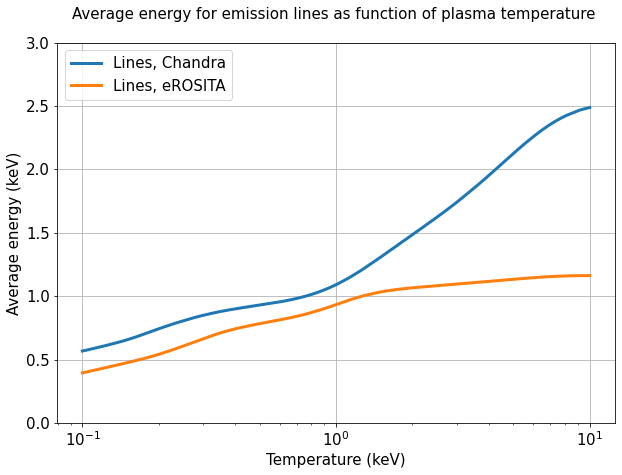

In [36]:
plt.figure(figsize=(10,7))

data_name1 = "data/stats_03.dat"   #'Lines, CH'
data_name2 = "data/stats_11.dat"   #'Cont, CH'
data_name3 = "data/stats_10.dat"   #'Lines, ER'
data_name4 = "data/stats_13.dat"   #'Cont, ER'
data_name5 = "data/stats_07.dat"   #'Lines, ER'
data_name6 = "data/stats_12.dat"   #'Lines, ER'

plot_E_T(data_name1, 'Lines', 'Chandra')
#plot_E_T(data_name2, 'Continuum', 'Chandra')
plot_E_T(data_name3, 'Lines', 'eROSITA')
#plot_E_T(data_name4, 'Continuum', 'eROSITA')
#plot_E_T(data_name6, 'Line2', 'er')


#for i in ['02', '03', '05', '08', '14', '15', '04', '16']:
#        dn = "data/stats_"+str(i)+".dat"
#        plot_E_T(dn, str(i), 'Chandra')

        
#plt.xscale('linear')

#add_T(1.0, 3.0, data_name1)

# comment if there is only one E(T)
# this move deletes unique titles
plt.title('Average energy for emission lines as function of plasma temperature \n', fontsize=15)
plt.grid()
#plt.savefig('letter26.10/Fig2.png')
plt.show()

# LINES ONLY

В этом блоке представлен алгоритм для вычисления $T_{spec}$ по спектрам (с преобладанием линий) двухкомпонентной плазмы разными способами и отображения его как на Рис.3 из публикации Вихлинина.

Алгоритм вычисления $T_{spec}$ по графикам $E \ (T)$ согласно формулам (1-3):

In [4]:
def get_Tspec_lines(fmin, Tmin, Tmax, Data):
    
    # derive T_spec from given values 
    # of T_min, T_max, f_min and for given <E>(T)

    E_1 = f(Tmin, Data[:,11], Data[:,2])
    E_2 = f(Tmax, Data[:,11], Data[:,2])

    S_j_1 = Data[np.argmin(np.abs(Data[:,2] - Tmin)), 9]
    S_j_2 = Data[np.argmin(np.abs(Data[:,2] - Tmax)), 9]
    
    #print(Data[np.argmin(np.abs(tList - Tmin)),9], Data[np.argmin(np.abs(tList - Tmax)),9])
    #print()

    num =    fmin*S_j_1*E_1 + (1-fmin)*S_j_2*E_2
    denom =  fmin*S_j_1     + (1-fmin)*S_j_2
    
    #Etot = num/denom
    #Tspec = f_inv(Etot, Data[:,11], Data[:,2])
    #plt.scatter(fmin, Tspec, color="blue")

    return f_inv(num/denom, Data[:,11], Data[:,2])


def plot_Tspec_fmin(Tmin, Tmax, N_fmins, Data, naive=False, lstyle = '-', cline = 'blue'):

    # draw plot like Fig.3

    f_min = np.linspace(0, 1, N_fmins+1)
    
    #naive weighting
    if naive:
        plt.plot(f_min, f_min*T_min+(1-f_min)*T_max, linestyle = '--', linewidth=2, color='black')

    T_spec = f_min*0

    for i in range(0, len(f_min)):

        T_spec[i] = get_Tspec_lines(f_min[i], T_min, T_max, Data)

    #print('*************')

    plt.plot(f_min, T_spec, linewidth=2, linestyle = lstyle, color = cline)
    #, label='eq. [1-3]')#'from '+str(T_max)+' to '+str(T_min))

def plot_Tspec_fmin_details():  
    
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.xlabel('$f_{min}$', fontsize = 15)
    plt.ylabel('$T_{spec}$ (keV)', fontsize = 15)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    line_n = Line2D([], [], label='Naive weighting', color='black', linestyle='--', linewidth=2)
    line_e = Line2D([], [], label='$T_{spec}$ from eq. [1-3]', color='blue', linestyle='-', linewidth=2)
    dots_f = Line2D([], [], label='Single-T fit', color='black', marker='.', linestyle='None', markersize=12)
    handles.extend([line_n, line_e, dots_f])
    plt.legend(handles=handles, fontsize=15)

## PyXspec

Defining a function that calculates single-temperature fit for two-component plasma (with line-dominated spectra) of temperatures $T_{min}$ and $T_{max}$ and relative contributions $f_{min}$ and $f_{max}$ respectively.

Note: to get rid of trace elements for pure bremsstrahlung use `xset APEC_TRACE_ABUND 0`.

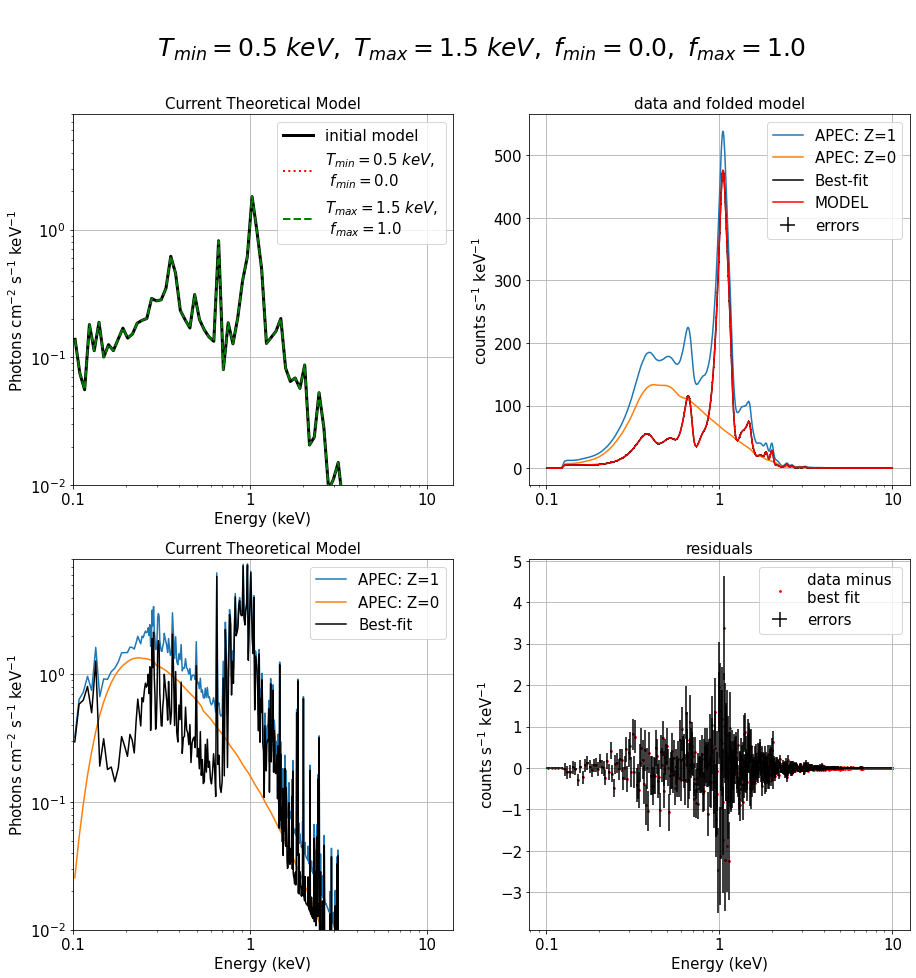

Plot command list is now empty


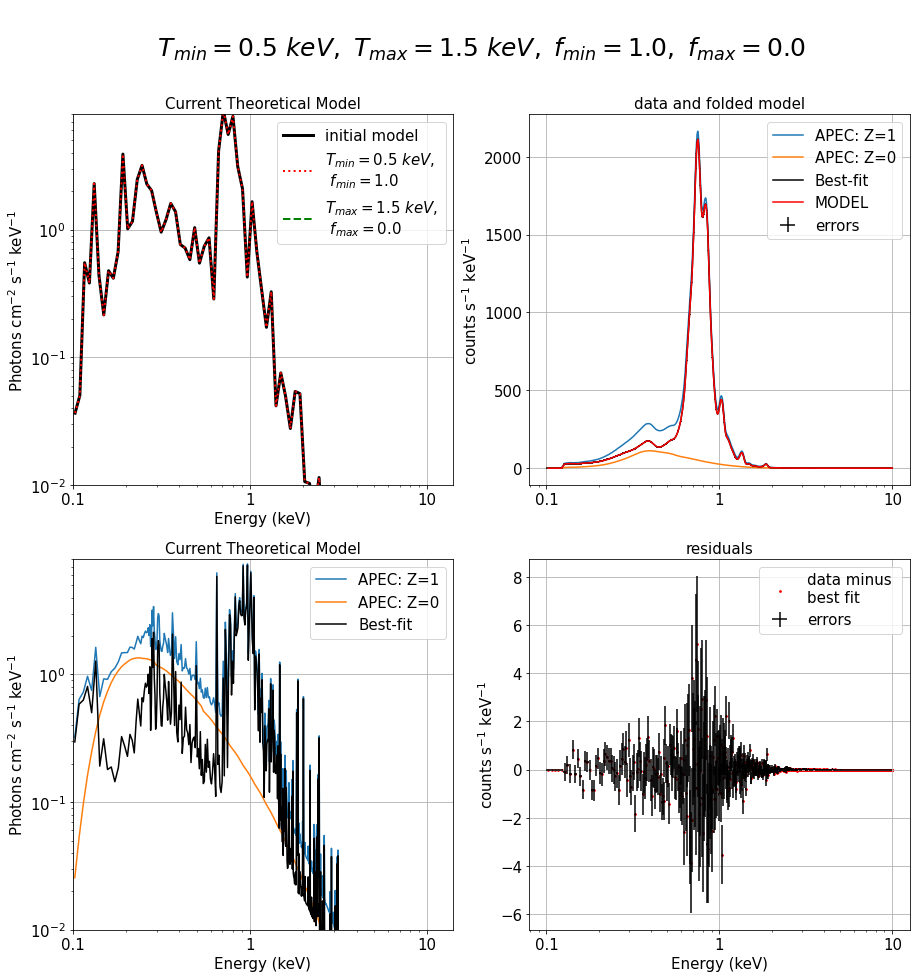

Plot command list is now empty
[1.4997226920736557, 0.49996239229652994]


In [77]:
def print_parnames(MODEL):
    
    ncomp = len(MODEL.componentNames)
    for icomp in MODEL.componentNames:
        print (icomp, eval(f'MODEL.{icomp}.parameterNames'))

#mod2fit111 = x.Model("phabs*(apec+const*apec)")
#print_parnames(mod2fit111)


def single_T_fit_lines(T_minnn, T_maxxx, N_fmins, telescope_name, plot=False, Xplot=False):

    x.AllData.removeDummyrsp()
    x.AllData.dummyrsp(lowE=0.1, highE=50.0, nBins=100)
    x.Xset.addModelString("APEC_TRACE_ABUND", "0")
    
    if telescope_name == 'Chandra':
        RMF_NAME = 'telescopes/chandra/djs50.ugc3957_v05.rmf' 
        ARF_NAME = 'telescopes/chandra/djs50.ugc3957_v05.arf' 
    elif telescope_name == 'eROSITA':
        RMF_NAME = 'telescopes/erosita/erosita_pirmf_v20210719.rmf'
        ARF_NAME = 'telescopes/erosita/tm1_arf_open_000101v02.fits'
    
    if Xplot:
        x.Plot.device = "/xs"
    else:
        x.Plot.device = '/null'

    tspec_list = []

    for l in range(1, N_fmins+2):
        
        f_minnn = 0.0+(1/N_fmins)*(l-1)
        f_maxxx = 1-f_minnn
        
        # set model for fakeit
        mod = x.Model('phabs*(const*(apec+const*apec)+const*(apec+const*apec))')
        mod.setPars(0.01, f_minnn, T_minnn, 1.0, 0, 1, 1., T_minnn, 0.0, 0, 1, f_maxxx, T_maxxx, 1.0, 0, 1, 1., T_maxxx, 0, 0, 1)
        #x.AllModels.show()
        mod(7).values =  "-1, 0.0001, -1, -1, 1, 1"
        mod(17).values = "-1, 0.0001, -1, -1, 1, 1"
        mod(7).frozen = True
        mod(17).frozen = True
        mod(8).link = "3"
        mod(10).link = "5"
        mod(11).link = "6"
        mod(18).link = "13"
        mod(20).link = "15"
        mod(21).link = "16"
        x.AllModels.show()
        #x.Plot.show()
        
        if plot:
            
            plt.figure(figsize=(15, 15))
            plt.suptitle(f'\n $T_{{min}}={T_minnn} \ keV, \ T_{{max}}={T_maxxx} \ keV, \ f_{{min}}={f_minnn}, \ f_{{max}}={f_maxxx}$', fontsize = 25)
            plt.subplot(2,2,1)
            x.Plot("model")
            x.Plot.add = True
            #x.Plot.setID()
            xVals = x.Plot.x()
            modVals = x.Plot.model()
            yAdd1 = x.Plot.addComp(1)
            yAdd2 = x.Plot.addComp(2)
            yAdd3 = x.Plot.addComp(3)
            yAdd4 = x.Plot.addComp(4)
            yAdd12 = [a+b for a,b in zip(yAdd1, yAdd2)]
            yAdd34 = [c+d for c,d in zip(yAdd3, yAdd4)]
            plt.plot(xVals, modVals, linewidth = 3, label='initial model', color='black')
            plt.plot(xVals, yAdd12, linewidth = 2, linestyle = ":", 
                     label=f'$T_{{min}}={T_minnn} \ keV$, \n $f_{{min}}={f_minnn}$', color='red')
            plt.plot(xVals, yAdd34, linewidth = 2, linestyle = "--", 
                     label=f'$T_{{max}}={T_maxxx} \ keV$, \n $f_{{max}}={f_maxxx}$', color='green')
            #plt.plot(xVals, [c+d for c,d in zip(yAdd12, yAdd34)], label='sum')
            #plt.plot(xVals, yAdd3, label='3')
            #plt.plot(xVals, yAdd4, label='4')
            plt.xscale('log')
            plt.yscale('log')
            plt.xlim(0.1, 14)
            plt.ylim(0.01, 8)
            plt.legend(fontsize = 15, loc=1)
            add_plt_fancy()
            #plt.show()

        # fake spectrum
        fs = x.FakeitSettings(response = RMF_NAME, 
                                   arf = ARF_NAME, 
                            background = '', 
                              exposure = '40000', 
                            correction = '', 
                          backExposure = '', 
                              fileName = 'fakeit.pha')
        x.AllData.fakeit(nSpectra = 1, 
                         settings = fs, 
                       applyStats = True,
                       filePrefix = "",
                          noWrite = True)
        
        x.AllData.ignore("**-0.1 10.-**")             # IMPORTANT !
        x.Plot("data")
        x.AllData.show()

        # fitting
        mod2fit = x.Model("phabs*(apec+const*apec)")
        mod2fit.setPars(0.01, 1.0, 1.0, 0., 1, 1, 1., 0.0, 0.0, 1)
        mod2fit(6).values = "-1, 0.0001, -1, -1, 1, 1"
        mod2fit(1).frozen = True
        mod2fit(6).frozen = True  
        mod2fit(7).link = "2"
        mod2fit(9).link = "4"
        mod2fit(10).link = "5"
        
        if plot:
            
            plt.subplot(2,2,3)
            x.Plot("model")
            modVals = x.Plot.model()
            xVals = x.Plot.x()
            y1 = x.Plot.addComp(1)
            y2 = x.Plot.addComp(2)
            plt.plot(xVals, y1, label="APEC: Z=1")
            #plt.plot(xVals, y2, label="2")
            #plt.plot(xVals, [c+d for c,d in zip(y1, y2)], label='sum')
            plt.plot(xVals, [-aa for aa in y2], label='APEC: Z=0')
            plt.plot(xVals, modVals, label="Best-fit", color='black')
            plt.xscale('log')
            plt.yscale('log')
            plt.xlim(0.1, 14)
            plt.ylim(0.01, 8)
            add_plt_fancy()
            #plt.title("Best-fit model")
            #plt.show()
            
        #print_parnames(mod2fit)
        
        #x.Fit.renorm('auto')
        x.Fit.nIterations = 100
        #x.Fit.statMethod = 'cstat'
        # about statistic in xspec:
        # https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node119.html
        x.Fit.query = 'yes'
        #x.Fit.steppar("2 delta 0.02 5")
        # about steppar:
        # https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node86.html
        x.Fit.perform()
        #x.Fit.error("1, 2, 5, 6, 10")
        #.Fit.error("9.0")
        # about error:
        # https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node79.html
        #x.Fit.perform()
        #x.AllModels.show()
        #x.Fit.show()
        best_kT = mod2fit(2).values[0]
        #print(best_kT)
        tspec_list.append(best_kT)
        
        if plot:
            
            plt.subplot(2,2,2)
            x.Plot("data")
            x.Plot.xAxis = "keV"
            x.Plot.add = True
            xVals = x.Plot.x()
            yVals = x.Plot.y()
            y1 = x.Plot.addComp(1)
            y2 = x.Plot.addComp(2)
            modVals = x.Plot.model()
            plt.plot(xVals, y1, label="APEC: Z=1")
            plt.plot(xVals, [-aa for aa in y2], label="APEC: Z=0")
            summa = [c+d for c,d in zip(y1, y2)]
            plt.plot(xVals, summa, label='Best-fit', color='black')
            plt.plot(xVals, modVals, label='MODEL', color='red')
            xErrs = x.Plot.xErr()
            yErrs = x.Plot.yErr()
            plt.errorbar(xVals, yVals, yErrs, xErrs, 
                         fmt = "none", ecolor = "black", label="errors")
            add_plt_fancy()
            plt.xlabel("")
            
            #plt.subplot(4,2,6)
            x.Plot("resid")
            plt.subplot(2,2,4)
            xValsR = x.Plot.x()
            yValsR = x.Plot.y()
            xErrsR = x.Plot.xErr()
            yErrsR = x.Plot.yErr()
            plt.errorbar(xValsR, yValsR, yErrsR, xErrsR, 
                         fmt = "none", ecolor = "black", label="errors")
            plt.scatter(xValsR, [a-b for a,b in zip(yVals, summa)], s=3, 
                        color='red', label='data minus \nbest fit')
            add_plt_fancy()
            
            #finally
            plt.show()     
            
        x.Plot("model data resid")
        x.Plot.commands=()
        x.AllData.clear()

    return tspec_list

#def add_background():
        #x.Plot("data")
        #bkg = x.Plot.backgroundVals()
        #plt.plot(xVals, yVals)
        
def add_plt_fancy():
    plt.xlabel(x.Plot.labels()[0], fontsize = 15)
    plt.ylabel(x.Plot.labels()[1], fontsize = 15)
    plt.title(x.Plot.labels()[2], fontsize = 15)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.grid()
    plt.xscale('log')
    plt.xticks([0.1, 1., 10.], [0.1, 1, 10])
    plt.legend(fontsize=15, loc=0)

fitlisttttt = single_T_fit_lines(0.50, 1.5, 1, 'eROSITA', plot=True, Xplot=False)
print(fitlisttttt)

#### Проработать:

1) Смысл `renorm`
2) `churazov` weights (для слабых источников)

## Figure 3

Reading from file (obsolete):

`fitlist = pd.read_csv("tspec_list.dat", header=None)[0].to_numpy().astype(float)`

`plt.scatter(np.linspace(0, 1, len(fitlist)), fitlist)`

Calculating one single-temperature fit (it was used for debugging):

`fitlist5 = single_T_fit_lines(0.50, 1.5, 4, 'Chandra', plot=True)`

In [22]:
#Tspec_lines_all[str(0.5)+'-'+str(1.5)] = single_T_fit_lines(0.5, 1.5, 3, telescope, plot = True)

Вычисляем всё необходимое в PyXspec:

In [99]:
telescope = 'Chandra' 
#telescope = 'eROSITA'

T_mins = (0.25, 0.5, 1., 0.5, 1.0)
T_maxs = (0.5, 1.0, 2.0, 1.5, 3.0)

Tspec_lines_all ={}

for T_min, T_max in list(zip(T_mins, T_maxs)):
    
    tspec_list = single_T_fit_lines(T_min, T_max, 20, telescope, plot = False)
    Tspec_lines_all[str(T_min)+'-'+str(T_max)] = tspec_list

Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot command list is now empty
Plot com

In [100]:
#print(Tspec_lines_all)
for key in Tspec_lines_all.keys():
    print(key, 'keV')
    print([f'{vl:.2f}' for vl in Tspec_lines_all[key]], '\n')

0.25-0.5 keV
['0.50', '0.49', '0.48', '0.47', '0.45', '0.44', '0.42', '0.40', '0.39', '0.38', '0.36', '0.35', '0.34', '0.33', '0.32', '0.30', '0.29', '0.28', '0.27', '0.26', '0.25'] 

0.5-1.0 keV
['1.00', '0.98', '0.96', '0.95', '0.93', '0.90', '0.89', '0.87', '0.84', '0.82', '0.79', '0.75', '0.71', '0.69', '0.66', '0.62', '0.59', '0.56', '0.54', '0.52', '0.50'] 

1.0-2.0 keV
['2.00', '1.75', '1.57', '1.41', '1.32', '1.25', '1.19', '1.14', '1.12', '1.11', '1.08', '1.07', '1.06', '1.05', '1.04', '1.03', '1.02', '1.01', '1.01', '1.00', '1.00'] 

0.5-1.5 keV
['1.50', '1.43', '1.40', '1.34', '1.28', '1.25', '1.14', '1.00', '0.73', '0.66', '0.63', '0.61', '0.59', '0.58', '0.56', '0.55', '0.54', '0.53', '0.52', '0.51', '0.50'] 

1.0-3.0 keV
['3.00', '2.36', '1.59', '1.29', '1.19', '1.13', '1.11', '1.08', '1.07', '1.06', '1.05', '1.04', '1.04', '1.03', '1.02', '1.02', '1.01', '1.01', '1.01', '1.00', '1.00'] 



Рисуем картинку:

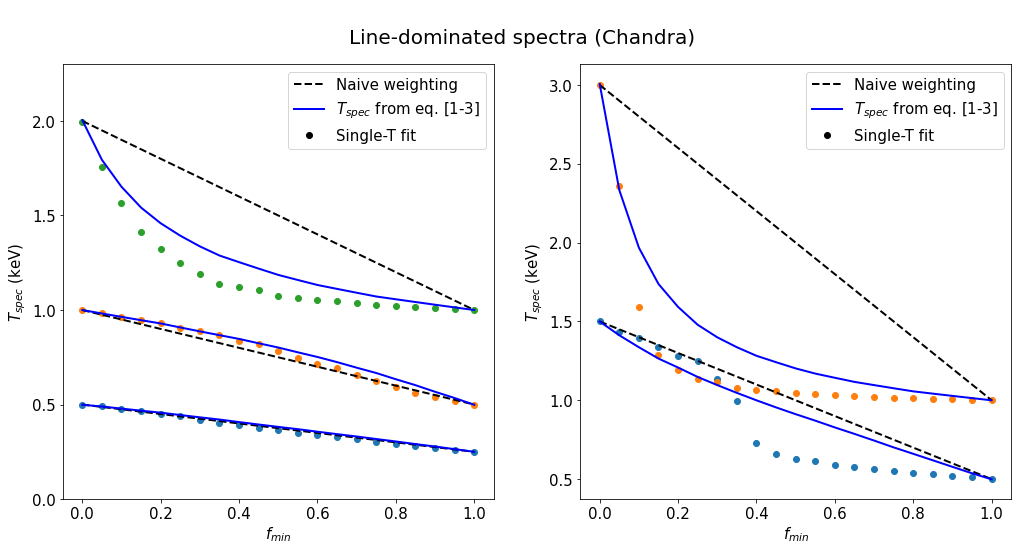

In [106]:
plt.figure(figsize=(17,8))
 
data__name = "data/stats_03.dat"

data = get_data(data__name, show_table=False)

plt.suptitle('\n' + 'Line-dominated spectra (' + telescope + ')', fontsize = 20)

plt.subplot(1,2,1)

T_mins = (0.25, 0.5, 1.)
T_maxs = (0.5, 1.0, 2.0)

for T_min, T_max in list(zip(T_mins, T_maxs)):
    
    # mean energy
    plot_Tspec_fmin(T_min, T_max, 20, data, naive=True, lstyle='-', cline='blue')
    plot_Tspec_fmin_details()
    
    # direct fit
    Tspec_list = Tspec_lines_all[str(T_min)+'-'+str(T_max)]
    plt.scatter(np.linspace(0, 1, len(Tspec_list)), Tspec_list)
    
    #plt.plot(np.linspace(0, 1, len(Tspec_list)), Tspec_list, color='black', linewidth=1)
    
plt.ylim(0, 2.3)

    
plt.subplot(1,2,2)

T_mins = (0.5, 1.0)
T_maxs = (1.5, 3.0)

for T_min, T_max in list(zip(T_mins, T_maxs)):
    
    # mean energy
    plot_Tspec_fmin(T_min, T_max, 20, data, naive=True, lstyle='-', cline='blue')
    plot_Tspec_fmin_details()
    
    #plot_Tspec_fmin(T_min, T_max, 20, get_data("data/stats_10.dat", show_table=False), naive=False, lstyle='-', cline='red')
    
    # direct fit
    Tspec_list = Tspec_lines_all[str(T_min)+'-'+str(T_max)]
    plt.scatter(np.linspace(0, 1, len(Tspec_list)), Tspec_list)
    
#plt.savefig('Fig3_'+telescope+'_'+data__name[11:13]+'.png')
plt.show()

# CONTINUUM ONLY

To show list of `xspec` commands use `x.Plot.commands`.
If something is not plotting, try `x.Plot.commands=()`.

In [148]:
def get_Tspec_continuum_eq45(fminnn, Tmin, Tmax):
    
    # derive T_spec from given values 
    # of T_min, T_max and f_min
    
    Tspec = []
    
    for fmin in fminnn:
        
        temperatures = [Tmin, Tmax]
        weights = temperatures*0

        alpha = 0.75
        
        weights = [temperatures[i]**(-alpha) for i in range(0, len(temperatures))]

        weights = np.multiply(weights, [fmin, (1-fmin)])

        #print(weights)

        num = np.dot(weights, temperatures)
        denom = sum(weights)

        #print(num/denom)
        
        Tspec.append(num/denom)

    return Tspec

#bbb = get_Tspec_continuum_eq5([0.2, 0.3], 1.0, 2.0)
#print(bbb)

# calculating photon count rate for continuum

def c_T(T, T_left, T_right, telescope_name, plot):
    
    x.AllData.removeDummyrsp()
    x.AllData.dummyrsp(lowE=0.1, highE=50.0, nBins=1024)
    x.Xset.addModelString("APEC_TRACE_ABUND", "0")
    
    if telescope_name == 'Chandra':
        RMF_NAME = 'telescopes/chandra/djs50.ugc3957_v05.rmf' 
        ARF_NAME = 'telescopes/chandra/djs50.ugc3957_v05.arf' 
    elif telescope_name == 'eROSITA':
        RMF_NAME = 'telescopes/erosita/erosita_pirmf_v20210719.rmf'
        ARF_NAME = 'telescopes/erosita/tm1_arf_open_000101v02.fits'

    # set model for fakeit
    
    mod = x.Model('phabs*apec')
    mod.setPars(0.01, T, 0.0, 0, 1)
    x.AllModels.show()
    
    if plot:
        x.Plot.device = '/xs'
    else:
        x.Plot.device = '/null'

    # fake spectrum
    fs = x.FakeitSettings(response = RMF_NAME, 
                               arf = ARF_NAME, 
                        background = '', 
                          exposure = '40000', 
                        correction = '', 
                      backExposure = '', 
                          fileName = 'fakeit.pha')
    x.AllData.fakeit(nSpectra = 1, 
                     settings = fs, 
                   applyStats = True,
                   filePrefix = "",
                      noWrite = True)

    x.AllData.ignore(f"**-{T_left} {T_right}-**")             # IMPORTANT !
    x.Plot.xAxis = "keV"
    #x.AllData.show()
    x.Plot("data")
    xVals = x.Plot.x()
    yVals = x.Plot.y()
    
    #plt.plot(xVals, yVals, label=str(T))
    #plt.xscale('log')
    #plt.legend()
    #plt.grid()
    #plt.show()

    return np.dot(xVals, yVals)    
    
#for i in range(0, 100):
#    ddd = c_T(i/10, 0.7, 10.0, 'Chandra')
#    print(ddd)

def get_Tspec_continuum_eq46(fminnn, Tmin, Tmax, telescope_name):
    
    # derive T_spec from given values 
    # of T_min, T_max and f_min
    
    Tspec = []
    
    for fmin in fminnn:
        
        temperatures = [Tmin, Tmax]
        weights = temperatures*0

        alpha = 0.75
        
        weights = [temperatures[i]**(-alpha) for i in range(0, len(temperatures))]

        weights = np.multiply(weights, [fmin, (1-fmin)])
        
        c_T_min = c_T(Tmin, 0.7, 10.0, telescope_name, plot=False)
        c_T_max = c_T(Tmax, 0.7, 10.0, telescope_name, plot=False)
        
        weights = np.multiply(weights, [c_T_min, c_T_max])

        #print(weights)

        num = np.dot(weights, temperatures)
        denom = sum(weights)

        #print(num/denom)
        
        Tspec.append(num/denom)

    return Tspec

#bbb = get_Tspec_continuum_eq5([0.2, 0.3], 1.0, 2.0)
#print(bbb)

### Mazotta-like fit
Single-T fit for mixture of 2 continuums (not working properly):

In [149]:
def get_Tspec_continuum_fit(T_minnn, T_maxxx, N_fmins, telescope_name, T_left_cutoff, plot=False, Xplot=False):

    x.AllData.removeDummyrsp()
    x.AllData.dummyrsp(lowE=0.1, highE=50.0, nBins=1024)
    x.Xset.addModelString("APEC_TRACE_ABUND", "0")
    
    if telescope_name == 'Chandra':
        RMF_NAME = 'telescopes/chandra/djs50.ugc3957_v05.rmf' 
        ARF_NAME = 'telescopes/chandra/djs50.ugc3957_v05.arf' 
    elif telescope_name == 'eROSITA':
        RMF_NAME = 'telescopes/erosita/erosita_pirmf_v20210719.rmf'
        ARF_NAME = 'telescopes/erosita/tm1_arf_open_000101v02.fits'
    
    if Xplot:
        x.Plot.device = "/xs"
    else:
        x.Plot.device = '/null'

    tspec_list = []

    for l in range(1, N_fmins+1):

        f_minnn = 0.0+(1/N_fmins)*(l-1)
        f_maxxx = 1-f_minnn
        
        # set model for fakeit
        mod = x.Model('phabs*(const*apec+const*apec)')
        mod.setPars(0.01, f_minnn, T_minnn, 0.0, 0, 1, f_maxxx, T_maxxx, 0.0, 0, 1)
        x.AllModels.show()
        
        if plot:
            
            plt.figure(figsize=(15, 15))
            plt.suptitle(f'\n $T_{{min}}={T_minnn} \ keV, \ T_{{max}}={T_maxxx} \ keV, \ f_{{min}}={f_minnn}, \ f_{{max}}={f_maxxx}$', fontsize = 25)
            plt.subplot(2,2,1)
            x.Plot("model")
            x.Plot.add = True
            #x.Plot.setID()
            xVals = x.Plot.x()
            modVals = x.Plot.model()
            yAdd1 = x.Plot.addComp(1)
            yAdd2 = x.Plot.addComp(2)
            #yAdd3 = x.Plot.addComp(3)
            #yAdd4 = x.Plot.addComp(4)
            #yAdd12 = [a+b for a,b in zip(yAdd1, yAdd2)]
            #yAdd34 = [c+d for c,d in zip(yAdd3, yAdd4)]
            plt.plot(xVals, modVals, linewidth = 3, label='initial model', color='black')
            plt.plot(xVals, yAdd1, linewidth = 2, linestyle = ":", 
                     label=f'$T_{{min}}={T_minnn} \ keV$, \n $f_{{min}}={f_minnn}$', color='red')
            plt.plot(xVals, yAdd2, linewidth = 2, linestyle = "--", 
                     label=f'$T_{{max}}={T_maxxx} \ keV$, \n $f_{{max}}={f_maxxx}$', color='green')
            #plt.plot(xVals, [c+d for c,d in zip(yAdd12, yAdd34)], label='sum')
            #plt.plot(xVals, yAdd3, label='3')
            #plt.plot(xVals, yAdd4, label='4')
            plt.xscale('log')
            plt.yscale('log')
            plt.xlim(0.1, 14)
            plt.ylim(0.01, 8)
            plt.legend(fontsize = 15, loc=1)
            add_plt_fancy()
            #plt.show()
            
        # fake spectrum
        fs = x.FakeitSettings(response = RMF_NAME, 
                                   arf = ARF_NAME, 
                            background = '', 
                              exposure = '40000', 
                            correction = '', 
                          backExposure = '', 
                              fileName = 'fakeit.pha')
        x.AllData.fakeit(nSpectra = 1, 
                         settings = fs, 
                       applyStats = True,
                       filePrefix = "",
                          noWrite = True)
        
        x.AllData.ignore(f"**-{T_left_cutoff} 10.-**")     # IMPORTANT !
        #x.Plot.xAxis = "keV"
        #x.Plot("data")
        x.AllData.show()
        #x.Plot("model data resid")
        #x.Plot("data")
        #x.Plot.add = True
        #x.Plot.background = False
        #bkg = x.Plot.backgroundVals()
        
        # fitting
        mod2fit = x.Model("phabs*apec")
        mod2fit.setPars(0.01, 1.0, 0.0, 0., 1)
        mod2fit(1).frozen = True
        
        x.Fit.nIterations = 100
        #x.Fit.statMethod = 'chi'
        # about statistic in xspec:
        # https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node119.html
        x.Fit.query = 'yes'
        x.Fit.perform()
        #x.AllModels.show()
        #x.Fit.show()
        best_kT = mod2fit(2).values[0]
        #print(best_kT)
        tspec_list.append(best_kT)
        
        if plot:
            
            plt.subplot(2,2,2)
            x.Plot("data")
            x.Plot.xAxis = "keV"
            x.Plot.add = True
            xVals = x.Plot.x()
            yVals = x.Plot.y()
            modVals = x.Plot.model()
            #y1 = x.Plot.addComp(1)
            #y2 = x.Plot.addComp(2)
            #plt.plot(xVals, y1, label="APEC: Z=1")
            #plt.plot(xVals, [-aa for aa in y2], label="APEC: Z=0")
            #summa = [c+d for c,d in zip(y1, y2)]
            plt.plot(xVals, modVals, label='Best-fit model', color='black')
            xErrs = x.Plot.xErr()
            yErrs = x.Plot.yErr()
            plt.errorbar(xVals, yVals, yErrs, xErrs, 
                         fmt = "none", ecolor = "blue", label="data with errors")
            add_plt_fancy_cont()
            plt.xlabel("")
            
            #plt.subplot(4,2,6)
            x.Plot("resid")
            plt.subplot(2,2,4)
            xValsR = x.Plot.x()
            yValsR = x.Plot.y()
            xErrsR = x.Plot.xErr()
            yErrsR = x.Plot.yErr()
            plt.errorbar(xValsR, yValsR, yErrsR, xErrsR, 
                         fmt = "none", ecolor = "black", label="errors")
            plt.scatter(xValsR, [a-b for a,b in zip(yVals, modVals)], s=3, 
                        color='red', label='data minus \nbest fit')
            add_plt_fancy_cont()
            
            #finally
            plt.show()     
            
        x.Plot("model data resid")
        #x.Plot.commands=()
        #x.AllData.clear()

    return tspec_list
        
def add_plt_fancy_cont():
    plt.xlabel(x.Plot.labels()[0], fontsize = 15)
    plt.ylabel(x.Plot.labels()[1], fontsize = 15)
    plt.title(x.Plot.labels()[2], fontsize = 15)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.grid()
    plt.xscale('log')
    plt.xticks([0.7, 1., 10.], [0.7, 1, 10])
    plt.legend(fontsize=15, loc=0)
    
#ccc = get_Tspec_continuum_fit(0.5, 2.0, 2, 'Chandra', 0.7, plot=False, Xplot=False)
#print(ccc)

## Figure 4

Вычисляем всё необходимое:

In [150]:
telescope = 'Chandra' 
#telescope = 'eROSITA'

f_min = np.linspace(0, 1, 21)
T_spec = f_min*0

T_mins = (0.25, 0.5, 1.0, 2.0, 4.0)
T_maxs = (1.0,  2.0, 4.0, 8.0, 16.0)

Tspec_from_eq46 ={}
Tspec_from_fit ={}

for T_min, T_max in list(zip(T_mins, T_maxs)):
    
    # Tspec from equations 4, 6
    tspec_list = get_Tspec_continuum_eq46(f_min, T_min, T_max, telescope)
    Tspec_from_eq46[str(T_min)+'-'+str(T_max)] = tspec_list
    
    # Tspec from direct fit
    tspec_list_1 = get_Tspec_continuum_fit(T_min, T_max, len(f_min), telescope, 0.7, plot=False, Xplot=False)
    Tspec_from_fit[str(T_min)+'-'+str(T_max)] = tspec_list_1

In [151]:
for key in Tspec_from_eq46.keys():
    print(key, 'keV')
    print('Eqs. 4, 6:', [f'{vl:.2f}' for vl in Tspec_from_eq46[key]], '\n')
    print('Direct fit', [f'{vl:.2f}' for vl in Tspec_from_fit[key]], '\n')

0.25-1.0 keV
Eqs. 4, 6: ['1.00', '0.99', '0.99', '0.98', '0.98', '0.97', '0.96', '0.95', '0.94', '0.93', '0.91', '0.90', '0.88', '0.85', '0.83', '0.79', '0.74', '0.68', '0.59', '0.47', '0.25'] 

Direct fit ['1.00', '1.00', '0.99', '0.99', '0.98', '0.98', '0.97', '0.97', '0.96', '0.95', '0.94', '0.93', '0.91', '0.90', '0.88', '0.85', '0.82', '0.76', '0.70', '0.59', '0.42'] 

0.5-2.0 keV
Eqs. 4, 6: ['2.00', '1.97', '1.93', '1.90', '1.86', '1.81', '1.77', '1.72', '1.67', '1.61', '1.55', '1.49', '1.42', '1.34', '1.25', '1.16', '1.06', '0.94', '0.81', '0.67', '0.50'] 

Direct fit ['2.00', '1.97', '1.94', '1.92', '1.89', '1.86', '1.82', '1.78', '1.74', '1.69', '1.64', '1.59', '1.52', '1.46', '1.38', '1.27', '1.18', '1.05', '0.93', '0.78', '0.63'] 

1.0-4.0 keV
Eqs. 4, 6: ['4.00', '3.87', '3.74', '3.60', '3.47', '3.33', '3.19', '3.05', '2.90', '2.76', '2.60', '2.46', '2.30', '2.15', '1.99', '1.83', '1.67', '1.51', '1.34', '1.17', '1.00'] 

Direct fit ['3.99', '3.87', '3.74', '3.62', '3.49', '

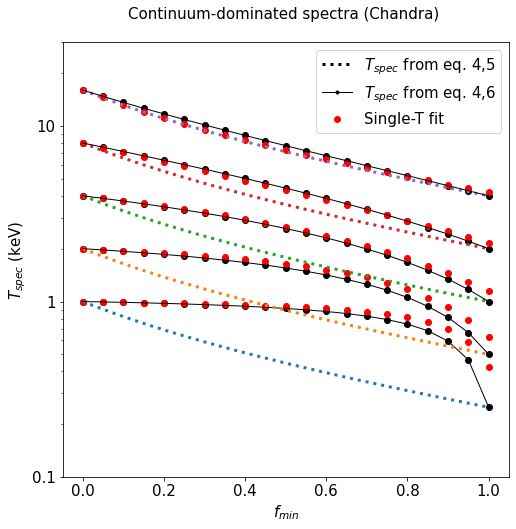

In [152]:
plt.figure(figsize=(8,8))

#telescope = 'Chandra' 
#telescope = 'eROSITA'

#print(f_min, T_spec, get_Tspec_continuum_eq5(f_min, T_min, T_max))

T_mins = (0.25, 0.5, 1.0, 2.0, 4.0)
T_maxs = (1.0,  2.0, 4.0, 8.0, 16.0)

for T_min, T_max in list(zip(T_mins, T_maxs)):
    
    # naive weighting
    #plt.plot(f_min, f_min*T_min+(1-f_min)*T_max, linestyle = '--', linewidth=2, color='black')
    
    # Tspec from equations 4, 5
    plt.plot(f_min, get_Tspec_continuum_eq5(f_min, T_min, T_max), linestyle = ':', linewidth = 3)

    # Tspec from equations 4, 6
    Tspec_list = Tspec_from_eq46[str(T_min)+'-'+str(T_max)]
    plt.plot(np.linspace(0, 1, len(Tspec_list)), Tspec_list, color='black', linewidth=1)
    plt.scatter(np.linspace(0, 1, len(Tspec_list)), Tspec_list, color='black')
    
    # Tspec from direct fit
    Tspec_list1 = Tspec_from_fit[str(T_min)+'-'+str(T_max)]
    plt.scatter(np.linspace(0, 1, len(Tspec_list1)), Tspec_list1, color='red')
    
    
plt.ylim(0.1, 30)
plt.yscale('log')
plt.xticks(size=15)
plt.yticks([0.1, 1, 10], [0.1, 1, 10], size=15)
plt.xlabel('$f_{min}$', fontsize = 15)
plt.ylabel('$T_{spec}$ (keV)', fontsize = 15)
plt.title('Continuum-dominated spectra ('+telescope+') \n', fontsize = 15)

handles, labels = plt.gca().get_legend_handles_labels()
#line_n = Line2D([], [], label='Naive weighting', color='black', linestyle='--', linewidth=2)
line_e = Line2D([], [], label='$T_{spec}$ from eq. 4,5', color='black', linestyle=':', linewidth=3)
dots_f = Line2D([], [], label='$T_{spec}$ from eq. 4,6', color='black', marker='.', linestyle='-', linewidth=1)
dots_T = Line2D([], [], label='Single-T fit', color='red', marker='.', linewidth=0, markersize=12)
handles.extend([line_e, dots_f, dots_T])
plt.legend(handles=handles, fontsize=15)

plt.savefig('Fig4_'+str(telescope)+'.png')
plt.show()

# REALISTIC METALLICITIES

In [163]:
def single_T_realistic(T_minnn, T_maxxx, N_fmins, Z, telescope_name, plot=False):

    x.AllData.removeDummyrsp()
    x.AllData.dummyrsp(lowE=0.1, highE=50.0, nBins=1024)
    
    if telescope_name == 'Chandra':
        RMF_NAME = 'telescopes/chandra/djs50.ugc3957_v05.rmf' 
        ARF_NAME = 'telescopes/chandra/djs50.ugc3957_v05.arf' 
    elif telescope_name == 'eROSITA':
        RMF_NAME = 'telescopes/erosita/erosita_pirmf_v20210719.rmf'
        ARF_NAME = 'telescopes/erosita/tm1_arf_open_000101v02.fits'
    
    x.Plot.device = "/xs"

    tspec_list = []

    for l in range(1, N_fmins+1):

        f_minnn = 0.0+(1/N_fmins)*(l-1)
        f_maxxx = 1-f_minnn
        
        # set model for fakeit
        mod = x.Model('phabs*(const*apec+const*apec)')
        mod.setPars(0.01, f_minnn, T_minnn, Z, 0, 1, f_maxxx, T_maxxx, Z, 0, 1)
        x.AllModels.show()
        #x.Plot.show()
        #x.Plot.xAxis = "keV"
        #if plot:
        #    x.Plot("model")
            
        # fake spectrum
        fs = x.FakeitSettings(response = RMF_NAME, 
                                   arf = ARF_NAME, 
                            background = '', 
                              exposure = '40000', 
                            correction = '', 
                          backExposure = '', 
                              fileName = 'fakeit.pha')
        x.AllData.fakeit(nSpectra = 1, 
                         settings = fs, 
                       applyStats = True,
                       filePrefix = "",
                          noWrite = True)
        
        x.AllData.ignore("**-0.1 10.-**")             # IMPORTANT !
        x.Plot.xAxis = "keV"
        #x.Plot("data")
        #x.AllData.show()
        x.Plot("model data resid")
        
        # fitting
        mod2fit = x.Model("phabs*apec")
        mod2fit.setPars(0.01, 1.0, Z, 0., 1)      
        x.Fit.nIterations = 100
        x.Fit.statMethod = 'chi'
        # about statistic in xspec:
        # https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node119.html
        x.Fit.query = 'yes'
        x.Fit.perform()

        #x.AllModels.show()
        #x.Fit.show()
        best_kT = mod2fit(2).values[0]
        #print(best_kT)
        tspec_list.append(best_kT)

    return tspec_list
        
        #return yVals
    #return
    
#aaa = single_T_realistic(1.0, 3.0, 10, 0.3, 'Chandra', plot=True)
#print(aaa)

In [243]:
telescope = 'Chandra' 
#telescope = 'eROSITA'

f_min = np.linspace(0, 1, 21)
T_spec = f_min*0

T_mins = (1.0, 2.0)
T_maxs = (3.0, 6.0)

Tspec_cont_all_fig5 ={}
single_T_fit_all_fig5={}

for T_min, T_max in list(zip(T_mins, T_maxs)):
    
    Tspec_cont_all_fig5[str(T_min)+'-'+str(T_max)] = get_Tspec_continuum_eq6(f_min, T_min, T_max, telescope)
    
    single_T_fit_all_fig5[str(T_min)+'-'+str(T_max)] = single_T_realistic(T_min, T_max, len(f_min), 0.3, telescope, plot=True)

In [244]:
#print(Tspec_cont_all)
for key in Tspec_cont_all_fig5.keys():
    print(key, 'keV')
    print([f'{vl:.2f}' for vl in Tspec_cont_all_fig5[key]], '\n')
    
for key in single_T_fit_all_fig5.keys():
    print(key, 'keV')
    print([f'{vl:.2f}' for vl in single_T_fit_all_fig5[key]], '\n')

1.0-3.0 keV
['3.00', '2.90', '2.81', '2.71', '2.61', '2.51', '2.42', '2.32', '2.22', '2.12', '2.02', '1.92', '1.82', '1.72', '1.62', '1.51', '1.41', '1.31', '1.21', '1.10', '1.00'] 

2.0-6.0 keV
['6.00', '5.71', '5.44', '5.18', '4.93', '4.69', '4.46', '4.24', '4.03', '3.82', '3.62', '3.44', '3.25', '3.08', '2.91', '2.74', '2.58', '2.43', '2.28', '2.14', '2.00'] 

1.0-3.0 keV
['2.99', '2.82', '2.64', '2.47', '2.30', '2.14', '1.99', '1.81', '1.68', '1.50', '1.35', '1.27', '1.20', '1.13', '1.12', '1.07', '1.06', '1.05', '1.04', '1.02', '1.01'] 

2.0-6.0 keV
['5.98', '5.66', '5.35', '5.03', '4.76', '4.50', '4.25', '4.03', '3.81', '3.62', '3.41', '3.26', '3.09', '2.93', '2.79', '2.64', '2.51', '2.38', '2.28', '2.18', '2.08'] 



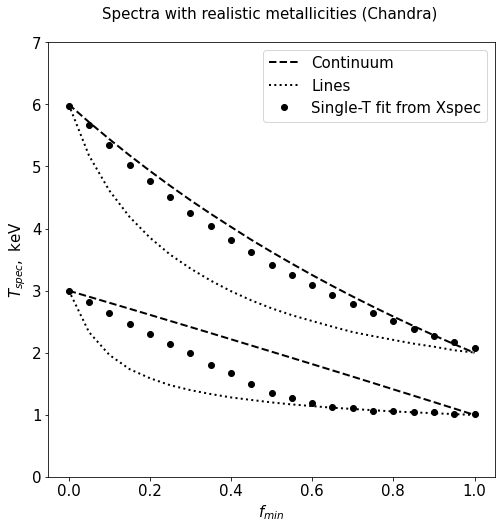

In [245]:
plt.figure(figsize=(8,8))

telescope = 'Chandra' 
#telescope = 'eROSITA'

f_min = np.linspace(0, 1, 21)
T_spec = f_min*0

T_mins = (1.0, 2.0)
T_maxs = (3.0, 6.0)

for T_min, T_max in list(zip(T_mins, T_maxs)):
    
    plot_Tspec_fmin(T_min, T_max, 20, get_data("data/stats_03.dat", show_table=False), naive=False, lstyle=':', cline='black')

    Tspec_list1 = Tspec_cont_all_fig5[str(T_min)+'-'+str(T_max)]
    plt.plot(f_min, Tspec_list1, linestyle = '--', linewidth = 2, color = 'black')
    
    Tspec_list2 = single_T_fit_all_fig5[str(T_min)+'-'+str(T_max)]
    plt.scatter(f_min, Tspec_list2, color='black')
    #Tspec_list = Tspec_cont_all[str(T_min)+'-'+str(T_max)]
    #plt.scatter(np.linspace(0, 1, len(Tspec_list)), Tspec_list, color='black')
    #plt.plot(np.linspace(0, 1, len(Tspec_list)), Tspec_list, color='black', linewidth=1)

    
handles, labels = plt.gca().get_legend_handles_labels()
line_n = Line2D([], [], label='Continuum', color='black', linestyle='--', linewidth=2)
line_e = Line2D([], [], label='Lines', color='black', linestyle=':', linewidth=2)
dots_f = Line2D([], [], label='Single-T fit from Xspec', color='black', marker='.', linestyle='None', markersize=12)
handles.extend([line_n, line_e, dots_f])
plt.legend(handles=handles, fontsize=15)
    
plt.ylim(0, 7)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel('$f_{min}$', fontsize = 15)
plt.ylabel('$T_{spec},$ keV', fontsize = 15)
plt.title('Spectra with realistic metallicities ('+telescope+') \n', fontsize = 15)
plt.savefig('Fig5_'+telescope+'.png')
plt.show()